In [1]:
import pyspark
import pyspark.sql  as pyspark_sql
import pyspark.sql.types as pyspark_types
import pyspark.sql.functions  as pyspark_functions
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import col, sum as sum_
from pyspark.sql.window import Window
from pyspark.sql.functions import coalesce, col, lag, lead, count
from pyspark.sql.functions import mean

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = pyspark_sql.SparkSession.builder.getOrCreate()

### COLOMBO - DENIYAYA/MATARA - NUWARA ELIYA DATASET

In [3]:
# Load the dataset
cmn_data = spark.read.csv("dataset/col_mat_nuw_output.csv", header=None, inferSchema=True)

In [4]:
cmn_data.printSchema()

root
 |-- _c0: double (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: date (nullable = true)
 |-- _c3: date (nullable = true)



In [5]:
cmn_data.show()

+--------------------+--------------+----------+----------+
|                 _c0|           _c1|       _c2|       _c3|
+--------------------+--------------+----------+----------+
|1.969834395781014...|Colombo Proper|2019-01-01|2019-01-02|
|2.625522171968594...|Colombo Proper|2019-01-02|2019-01-03|
|9.852118897938794E-5|Colombo Proper|2019-01-03|2019-01-04|
|2.099320518114242E-4|Colombo Proper|2019-01-04|2019-01-05|
|1.785337298892930...|Colombo Proper|2019-01-05|2019-01-06|
|1.082296700235670...|Colombo Proper|2019-01-06|2019-01-07|
|3.926829280477309...|Colombo Proper|2019-01-07|2019-01-08|
|9.153156350685351E-5|Colombo Proper|2019-01-08|2019-01-09|
|1.205978992853015...|Colombo Proper|2019-01-09|2019-01-10|
|1.297723562983258...|Colombo Proper|2019-01-10|2019-01-11|
|2.239188166801278...|Colombo Proper|2019-01-11|2019-01-12|
|1.569418094178759...|Colombo Proper|2019-01-12|2019-01-13|
|                NULL|Colombo Proper|2019-01-13|2019-01-14|
|1.336291906862603...|Colombo Proper|201

In [6]:
# Define the new column names
column_names = ['HCHO Reading', 'Location', 'Current Date', 'Next Date']

# Rename the columns
for i, new_name in enumerate(column_names):
    cmn_data = cmn_data.withColumnRenamed(cmn_data.columns[i], new_name)

cmn_data.show()

+--------------------+--------------+------------+----------+
|        HCHO Reading|      Location|Current Date| Next Date|
+--------------------+--------------+------------+----------+
|1.969834395781014...|Colombo Proper|  2019-01-01|2019-01-02|
|2.625522171968594...|Colombo Proper|  2019-01-02|2019-01-03|
|9.852118897938794E-5|Colombo Proper|  2019-01-03|2019-01-04|
|2.099320518114242E-4|Colombo Proper|  2019-01-04|2019-01-05|
|1.785337298892930...|Colombo Proper|  2019-01-05|2019-01-06|
|1.082296700235670...|Colombo Proper|  2019-01-06|2019-01-07|
|3.926829280477309...|Colombo Proper|  2019-01-07|2019-01-08|
|9.153156350685351E-5|Colombo Proper|  2019-01-08|2019-01-09|
|1.205978992853015...|Colombo Proper|  2019-01-09|2019-01-10|
|1.297723562983258...|Colombo Proper|  2019-01-10|2019-01-11|
|2.239188166801278...|Colombo Proper|  2019-01-11|2019-01-12|
|1.569418094178759...|Colombo Proper|  2019-01-12|2019-01-13|
|                NULL|Colombo Proper|  2019-01-13|2019-01-14|
|1.33629

In [7]:
# Data description of HCHO Reading column
cmn_data.describe('HCHO Reading').show()

+-------+--------------------+
|summary|        HCHO Reading|
+-------+--------------------+
|  count|                3059|
|   mean|1.200429799620477...|
| stddev|1.009218095609297E-4|
|    min|-2.59296176552668...|
|    max|8.997101837438971E-4|
+-------+--------------------+



In [8]:
unique_locations_count = cmn_data.select("Location").distinct().count()
print(f"Number of unique values in the 'Location' column: {unique_locations_count}")
cmn_data.select("Location").distinct().show()

Number of unique values in the 'Location' column: 3
+-------------------+
|           Location|
+-------------------+
|   Deniyaya, Matara|
|     Colombo Proper|
|Nuwara Eliya Proper|
+-------------------+



In [9]:
# Checking the sum of the Null values
cmn_data.select(*[sum_(col(c).isNull().cast("int")).alias(c) for c in cmn_data.columns]).show()


+------------+--------+------------+---------+
|HCHO Reading|Location|Current Date|Next Date|
+------------+--------+------------+---------+
|        2419|       0|           0|        0|
+------------+--------+------------+---------+



In [10]:
# # Define the window specification for backward fill
# backward_windowSpec = Window.orderBy("Current Date")

# # Use lag to get the previous value in 'HCHO Reading'
# previous_value = lag("HCHO Reading", 1, None).over(backward_windowSpec)

# # Replace nulls in 'HCHO Reading' with the previous non-null value
# # We're using coalesce to keep the current value if it's not null or replace it with the previous value if it is null
# cmn_data = cmn_data.withColumn("HCHO Reading", coalesce("HCHO Reading", previous_value))

In [11]:
# # Define the window specification with the correct ordering column
# windowSpec = Window.orderBy("Current Date")  # Adjust if there's a more appropriate column

# # Use lead to get the next value in 'HCHO Reading'
# next_value = lead("HCHO Reading", 1, None).over(windowSpec)

# # Replace nulls in 'HCHO Reading' with the next non-null value
# cmn_data = cmn_data.withColumn("HCHO Reading", coalesce("HCHO Reading", next_value))


In [12]:
# Initialize a counter for null values
null_count = cmn_data.filter(col("HCHO Reading").isNull()).count()

# Continue the process until there are no nulls left
while null_count > 0:
    # Define the window specifications
    backward_windowSpec = Window.orderBy("Current Date")
    forward_windowSpec = Window.orderBy("Current Date")
    
    # Use lag to carry the last observation forward
    previous_value = lag("HCHO Reading", 1).over(backward_windowSpec)
    cmn_data = cmn_data.withColumn("HCHO Reading", coalesce("HCHO Reading", previous_value))
    
    # Use lead to carry the next observation backward
    next_value = lead("HCHO Reading", 1).over(forward_windowSpec)
    cmn_data = cmn_data.withColumn("HCHO Reading", coalesce("HCHO Reading", next_value))
    
    # Update the null count
    null_count = cmn_data.filter(col("HCHO Reading").isNull()).count()

In [13]:
cmn_data.select(*[sum_(col(c).isNull().cast("int")).alias(c) for c in cmn_data.columns]).show()

+------------+--------+------------+---------+
|HCHO Reading|Location|Current Date|Next Date|
+------------+--------+------------+---------+
|           0|       0|           0|        0|
+------------+--------+------------+---------+



In [14]:
dataset_length = cmn_data.count()
print("The length of the dataset is:", dataset_length)

The length of the dataset is: 5478


In [15]:
cmn_data = cmn_data.dropDuplicates()

In [16]:
dataset_length = cmn_data.count()
print("The length of the dataset after dropping dupplicates is:", dataset_length)

The length of the dataset is: 5478


In [17]:
# Convert the PySpark DataFrame to a Pandas DataFrame
cmn_data = cmn_data.toPandas()
cmn_data

,HCHO Reading,Location,Current Date,Next Date
0,0.000197,Colombo Proper,2019-01-01,2019-01-02
1,0.000197,"Deniyaya, Matara",2019-01-01,2019-01-02
2,0.000263,Nuwara Eliya Proper,2019-01-01,2019-01-02
3,0.000263,Colombo Proper,2019-01-02,2019-01-03
4,0.000006,"Deniyaya, Matara",2019-01-02,2019-01-03
...,...,...,...,...
5473,0.000080,Colombo Proper,2023-12-31,2024-01-01
5474,0.000080,"Deniyaya, Matara",2023-12-31,2024-01-01
5475,0.000080,Nuwara Eliya Proper,2023-12-31,2024-01-01
5476,0.000254,Colombo Proper,2022-03-07,2022-03-08


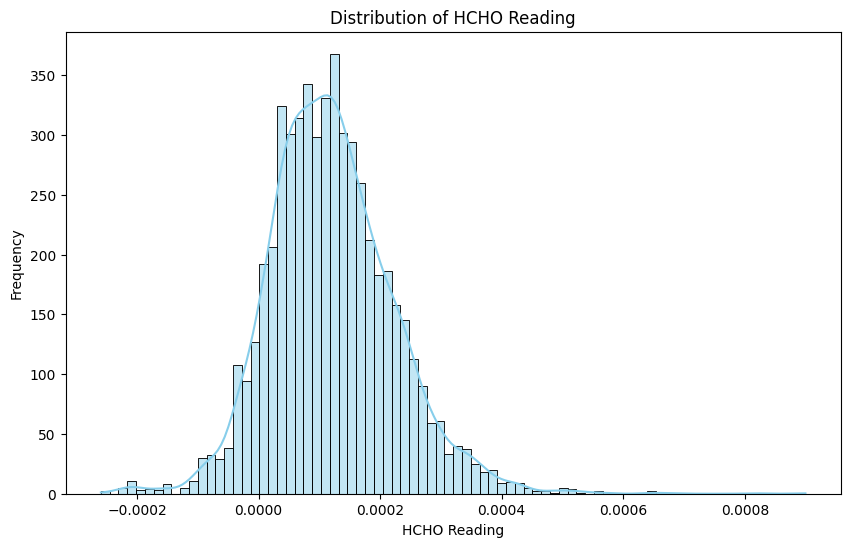

In [18]:
# Plot the distribution of the "HCHO Reading" column
plt.figure(figsize=(10, 6))
sns.histplot(cmn_data["HCHO Reading"], kde=True, color='skyblue')
plt.title('Distribution of HCHO Reading')
plt.xlabel('HCHO Reading')
plt.ylabel('Frequency')
plt.show()

In [19]:
cmn_data.to_csv("preprocessed_dataset/col_mat_nuw_pp.csv", index=False)

### KANDY DATASET

In [20]:
# Load the dataset
kan_data = spark.read.csv("dataset/kan_output.csv", header=None, inferSchema=True)

In [21]:
kan_data.printSchema()

root
 |-- _c0: double (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: date (nullable = true)
 |-- _c3: date (nullable = true)



In [22]:
kan_data.show()

+--------------------+------------+----------+----------+
|                 _c0|         _c1|       _c2|       _c3|
+--------------------+------------+----------+----------+
|1.760713459877335...|Kandy Proper|2019-01-01|2019-01-02|
|9.220391253917748E-5|Kandy Proper|2019-01-02|2019-01-03|
|                NULL|Kandy Proper|2019-01-03|2019-01-04|
|1.908681983853839...|Kandy Proper|2019-01-04|2019-01-05|
|1.219517840206744...|Kandy Proper|2019-01-05|2019-01-06|
|-6.51408612938880...|Kandy Proper|2019-01-06|2019-01-07|
|  1.6323820639265E-4|Kandy Proper|2019-01-07|2019-01-08|
|-6.73520553391426...|Kandy Proper|2019-01-08|2019-01-09|
|1.279693658243135...|Kandy Proper|2019-01-09|2019-01-10|
|4.546048424126012E-5|Kandy Proper|2019-01-10|2019-01-11|
|3.600074175192105E-5|Kandy Proper|2019-01-11|2019-01-12|
|1.286629698010177E-4|Kandy Proper|2019-01-12|2019-01-13|
|                NULL|Kandy Proper|2019-01-13|2019-01-14|
|                NULL|Kandy Proper|2019-01-14|2019-01-15|
| 9.6363963467

In [23]:
# Define the new column names
column_names = ['HCHO Reading', 'Location', 'Current Date', 'Next Date']

# Rename the columns
for i, new_name in enumerate(column_names):
    kan_data = kan_data.withColumnRenamed(kan_data.columns[i], new_name)

kan_data.show()

+--------------------+------------+------------+----------+
|        HCHO Reading|    Location|Current Date| Next Date|
+--------------------+------------+------------+----------+
|1.760713459877335...|Kandy Proper|  2019-01-01|2019-01-02|
|9.220391253917748E-5|Kandy Proper|  2019-01-02|2019-01-03|
|                NULL|Kandy Proper|  2019-01-03|2019-01-04|
|1.908681983853839...|Kandy Proper|  2019-01-04|2019-01-05|
|1.219517840206744...|Kandy Proper|  2019-01-05|2019-01-06|
|-6.51408612938880...|Kandy Proper|  2019-01-06|2019-01-07|
|  1.6323820639265E-4|Kandy Proper|  2019-01-07|2019-01-08|
|-6.73520553391426...|Kandy Proper|  2019-01-08|2019-01-09|
|1.279693658243135...|Kandy Proper|  2019-01-09|2019-01-10|
|4.546048424126012E-5|Kandy Proper|  2019-01-10|2019-01-11|
|3.600074175192105E-5|Kandy Proper|  2019-01-11|2019-01-12|
|1.286629698010177E-4|Kandy Proper|  2019-01-12|2019-01-13|
|                NULL|Kandy Proper|  2019-01-13|2019-01-14|
|                NULL|Kandy Proper|  201

In [24]:
# Data description of HCHO Reading column
kan_data.describe('HCHO Reading').show()

+-------+--------------------+
|summary|        HCHO Reading|
+-------+--------------------+
|  count|                1033|
|   mean|1.063760956208845...|
| stddev|9.202571862518035E-5|
|    min|-2.99702863135199...|
|    max|7.051621763962024E-4|
+-------+--------------------+



In [25]:
unique_locations_count = kan_data.select("Location").distinct().count()
print(f"Number of unique values in the 'Location' column: {unique_locations_count}")
kan_data.select("Location").distinct().show()

Number of unique values in the 'Location' column: 1
+------------+
|    Location|
+------------+
|Kandy Proper|
+------------+



In [26]:
# Checking the sum of the Null values
kan_data.select(*[sum_(col(c).isNull().cast("int")).alias(c) for c in kan_data.columns]).show()

+------------+--------+------------+---------+
|HCHO Reading|Location|Current Date|Next Date|
+------------+--------+------------+---------+
|         793|       0|           0|        0|
+------------+--------+------------+---------+



In [27]:
# Initialize a counter for null values
null_count = kan_data.filter(col("HCHO Reading").isNull()).count()

# Continue the process until there are no nulls left
while null_count > 0:
    # Define the window specifications
    backward_windowSpec = Window.orderBy("Current Date")
    forward_windowSpec = Window.orderBy("Current Date")
    
    # Use lag to carry the last observation forward
    previous_value = lag("HCHO Reading", 1).over(backward_windowSpec)
    kan_data = kan_data.withColumn("HCHO Reading", coalesce("HCHO Reading", previous_value))
    
    # Use lead to carry the next observation backward
    next_value = lead("HCHO Reading", 1).over(forward_windowSpec)
    kan_data = kan_data.withColumn("HCHO Reading", coalesce("HCHO Reading", next_value))
    
    # Update the null count
    null_count = kan_data.filter(col("HCHO Reading").isNull()).count()

In [28]:
kan_data.select(*[sum_(col(c).isNull().cast("int")).alias(c) for c in cmn_data.columns]).show()

+------------+--------+------------+---------+
|HCHO Reading|Location|Current Date|Next Date|
+------------+--------+------------+---------+
|           0|       0|           0|        0|
+------------+--------+------------+---------+



In [30]:
dataset_length = kan_data.count()
print("The length of the dataset is:", dataset_length)

The length of the dataset is: 1826


In [32]:
kan_data = kan_data.dropDuplicates()

In [33]:
dataset_length = kan_data.count()
print("The length of the dataset after dropping duplicates is:", dataset_length)

The length of the dataset after dropping duplicates is: 1826


In [34]:
# Convert the PySpark DataFrame to a Pandas DataFrame
kan_data = kan_data.toPandas()
kan_data

,HCHO Reading,Location,Current Date,Next Date
0,0.000176,Kandy Proper,2019-01-01,2019-01-02
1,0.000092,Kandy Proper,2019-01-02,2019-01-03
2,0.000092,Kandy Proper,2019-01-03,2019-01-04
3,0.000191,Kandy Proper,2019-01-04,2019-01-05
4,0.000122,Kandy Proper,2019-01-05,2019-01-06
...,...,...,...,...
1821,0.000056,Kandy Proper,2023-12-27,2023-12-28
1822,0.000056,Kandy Proper,2023-12-28,2023-12-29
1823,0.000056,Kandy Proper,2023-12-29,2023-12-30
1824,0.000056,Kandy Proper,2023-12-30,2023-12-31


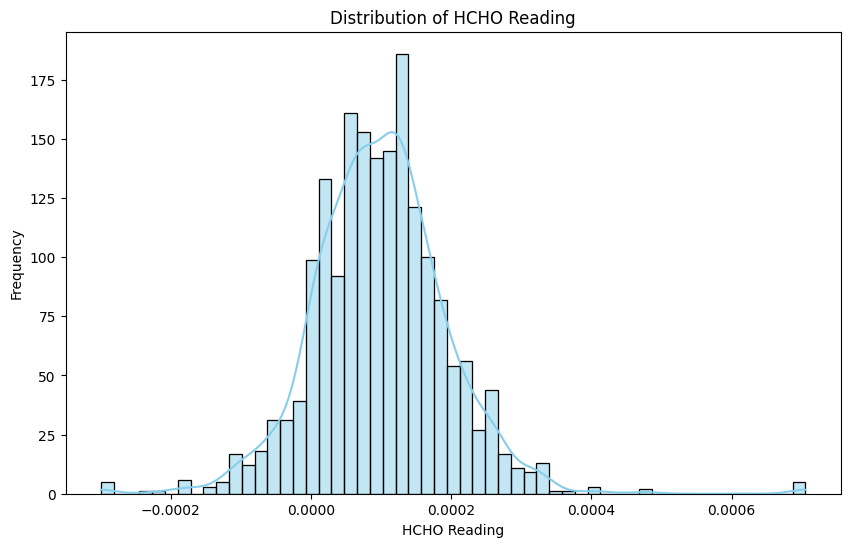

In [35]:
# Plot the distribution of the "HCHO Reading" column
plt.figure(figsize=(10, 6))
sns.histplot(kan_data["HCHO Reading"], kde=True, color='skyblue')
plt.title('Distribution of HCHO Reading')
plt.xlabel('HCHO Reading')
plt.ylabel('Frequency')
plt.show()

In [36]:
cmn_data.to_csv("preprocessed_dataset/kan_pp.csv", index=False)

### KURUNEGALA - BIBILE/MONARAGALA - JAFFNA DATASET

In [40]:
# Load the dataset
mkj_data = spark.read.csv("dataset/mon_kur_jaf_output.csv", header=None, inferSchema=True)

In [41]:
mkj_data.printSchema()

root
 |-- _c0: double (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: date (nullable = true)
 |-- _c3: date (nullable = true)



In [42]:
mkj_data.show()

+--------------------+------------------+----------+----------+
|                 _c0|               _c1|       _c2|       _c3|
+--------------------+------------------+----------+----------+
|                NULL|Bibile, Monaragala|2019-01-01|2019-01-02|
|1.919914652467399E-5|Bibile, Monaragala|2019-01-02|2019-01-03|
|2.811447935930283...|Bibile, Monaragala|2019-01-03|2019-01-04|
|3.747998184385943E-5|Bibile, Monaragala|2019-01-04|2019-01-05|
|-1.79826087934531...|Bibile, Monaragala|2019-01-05|2019-01-06|
|1.457836896179902...|Bibile, Monaragala|2019-01-06|2019-01-07|
|2.828590802546534...|Bibile, Monaragala|2019-01-07|2019-01-08|
|                NULL|Bibile, Monaragala|2019-01-08|2019-01-09|
|1.420850167050957...|Bibile, Monaragala|2019-01-09|2019-01-10|
|                NULL|Bibile, Monaragala|2019-01-10|2019-01-11|
|2.014587947072581E-5|Bibile, Monaragala|2019-01-11|2019-01-12|
|1.582787663210183...|Bibile, Monaragala|2019-01-12|2019-01-13|
|                NULL|Bibile, Monaragala

In [43]:
# Define the new column names
column_names = ['HCHO Reading', 'Location', 'Current Date', 'Next Date']

# Rename the columns
for i, new_name in enumerate(column_names):
    mkj_data = mkj_data.withColumnRenamed(mkj_data.columns[i], new_name)

mkj_data.show()

+--------------------+------------------+------------+----------+
|        HCHO Reading|          Location|Current Date| Next Date|
+--------------------+------------------+------------+----------+
|                NULL|Bibile, Monaragala|  2019-01-01|2019-01-02|
|1.919914652467399E-5|Bibile, Monaragala|  2019-01-02|2019-01-03|
|2.811447935930283...|Bibile, Monaragala|  2019-01-03|2019-01-04|
|3.747998184385943E-5|Bibile, Monaragala|  2019-01-04|2019-01-05|
|-1.79826087934531...|Bibile, Monaragala|  2019-01-05|2019-01-06|
|1.457836896179902...|Bibile, Monaragala|  2019-01-06|2019-01-07|
|2.828590802546534...|Bibile, Monaragala|  2019-01-07|2019-01-08|
|                NULL|Bibile, Monaragala|  2019-01-08|2019-01-09|
|1.420850167050957...|Bibile, Monaragala|  2019-01-09|2019-01-10|
|                NULL|Bibile, Monaragala|  2019-01-10|2019-01-11|
|2.014587947072581E-5|Bibile, Monaragala|  2019-01-11|2019-01-12|
|1.582787663210183...|Bibile, Monaragala|  2019-01-12|2019-01-13|
|         

In [44]:
# Data description of HCHO Reading column
mkj_data.describe('HCHO Reading').show()

+-------+--------------------+
|summary|        HCHO Reading|
+-------+--------------------+
|  count|                3826|
|   mean|1.221495984357837E-4|
| stddev|8.663968642569532E-5|
|    min|-3.52473024357239...|
|    max|5.837611392919413E-4|
+-------+--------------------+



In [45]:
unique_locations_count = mkj_data.select("Location").distinct().count()
print(f"Number of unique values in the 'Location' column: {unique_locations_count}")
mkj_data.select("Location").distinct().show()

Number of unique values in the 'Location' column: 3
+------------------+
|          Location|
+------------------+
| Kurunegala Proper|
|Bibile, Monaragala|
|     Jaffna Proper|
+------------------+



In [46]:
# Checking the sum of the Null values
mkj_data.select(*[sum_(col(c).isNull().cast("int")).alias(c) for c in mkj_data.columns]).show()

+------------+--------+------------+---------+
|HCHO Reading|Location|Current Date|Next Date|
+------------+--------+------------+---------+
|        1652|       0|           0|        0|
+------------+--------+------------+---------+



In [47]:
# Initialize a counter for null values
null_count = mkj_data.filter(col("HCHO Reading").isNull()).count()

# Continue the process until there are no nulls left
while null_count > 0:
    # Define the window specifications
    backward_windowSpec = Window.orderBy("Current Date")
    forward_windowSpec = Window.orderBy("Current Date")
    
    # Use lag to carry the last observation forward
    previous_value = lag("HCHO Reading", 1).over(backward_windowSpec)
    mkj_data = mkj_data.withColumn("HCHO Reading", coalesce("HCHO Reading", previous_value))
    
    # Use lead to carry the next observation backward
    next_value = lead("HCHO Reading", 1).over(forward_windowSpec)
    mkj_data = mkj_data.withColumn("HCHO Reading", coalesce("HCHO Reading", next_value))
    
    # Update the null count
    null_count = mkj_data.filter(col("HCHO Reading").isNull()).count()

In [48]:
mkj_data.select(*[sum_(col(c).isNull().cast("int")).alias(c) for c in mkj_data.columns]).show()

+------------+--------+------------+---------+
|HCHO Reading|Location|Current Date|Next Date|
+------------+--------+------------+---------+
|           0|       0|           0|        0|
+------------+--------+------------+---------+



In [49]:
dataset_length = mkj_data.count()
print("The length of the dataset is:", dataset_length)

The length of the dataset is: 5478


In [50]:
mkj_data = mkj_data.dropDuplicates()

In [51]:
dataset_length = mkj_data.count()
print("The length of the dataset is:", dataset_length)

The length of the dataset is: 5478


In [52]:
# Convert the PySpark DataFrame to a Pandas DataFrame
mkj_data = mkj_data.toPandas()
mkj_data

,HCHO Reading,Location,Current Date,Next Date
0,0.000088,"Bibile, Monaragala",2019-01-01,2019-01-02
1,0.000088,Kurunegala Proper,2019-01-01,2019-01-02
2,0.000058,Jaffna Proper,2019-01-01,2019-01-02
3,0.000019,"Bibile, Monaragala",2019-01-02,2019-01-03
4,0.000137,Kurunegala Proper,2019-01-02,2019-01-03
...,...,...,...,...
5473,0.000117,Jaffna Proper,2023-12-30,2023-12-31
5474,0.000117,"Bibile, Monaragala",2023-12-31,2024-01-01
5475,0.000065,Kurunegala Proper,2023-12-31,2024-01-01
5476,0.000065,Jaffna Proper,2023-12-31,2024-01-01


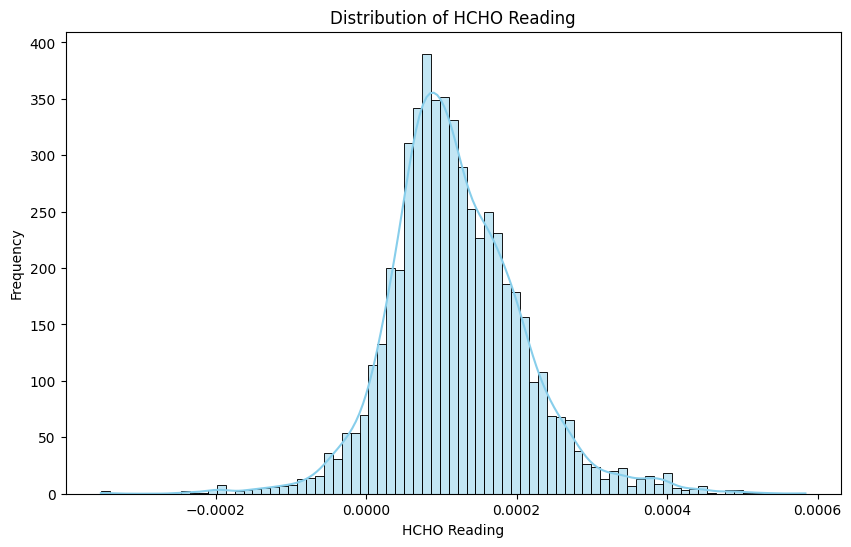

In [53]:
# Plot the distribution of the "HCHO Reading" column
plt.figure(figsize=(10, 6))
sns.histplot(mkj_data["HCHO Reading"], kde=True, color='skyblue')
plt.title('Distribution of HCHO Reading')
plt.xlabel('HCHO Reading')
plt.ylabel('Frequency')
plt.show()

In [54]:
mkj_data.to_csv("preprocessed_dataset/mon_kur_jaf_pp.csv", index=False)